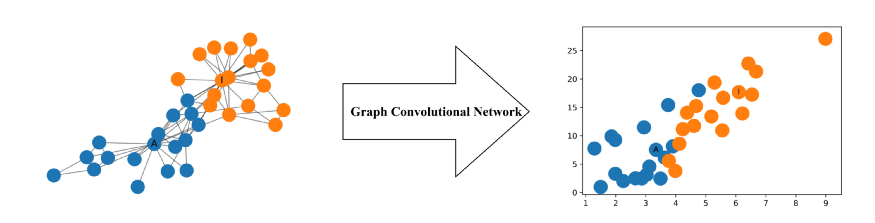

In [47]:
import numpy as np
import torch
import torch.nn as nn

# A simple Graph Example

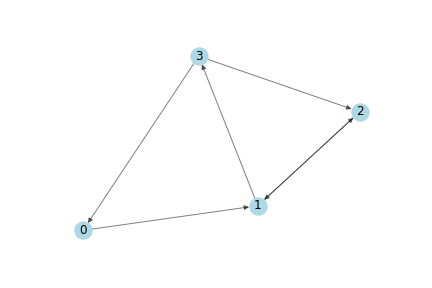

- node0: node1과 연결
- node1: node2와 node3과 연결
- node2: node1과 연결
- node3: node0과 node2와 연결

## Adjacency Matrix Representation(인접행렬 생성)

In [4]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float)
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

## Generate 2 integer features for every node based on its index

In [5]:
print(A.shape)
print(A.shape[0])

(4, 4)
4


In [6]:
x = np.matrix([
    [i,-i]
    for i in range(A.shape[0])],
    dtype=float)
x

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

# Applying the Propagation Rule

In [8]:
A*x

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

- the representation of each node is now a sum of its neighbors features
- in other words, the graph convolutional layer represents each node as an aggregate of its neighborhood.

[Problem]
1. the aggregated representation of ***a node does not include its own features***
  - the representation is an aggregate of the features of neighbor nodes, so only nodes that has a self-loop will inclue their own features in the aggregate

2. Nodes with large degrees will have large values in their feature representation. -> ***exploding gradient***

3. Nodes with small degrees will have small values -> **vanishing gradient**


[Solution]

- first problem -> add a self-loop
- second, third problem -> normalization

### Add a Self-Loop

In [9]:
# 대각행렬 생성 -> self-loop 추가 -> 자기 자신의 feature 추가
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [10]:
A_hat = A + I
A_hat*x

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Since the node is now a neighbor of itself, the node's own features is included when summing up the features of its neighbors!

### Normalizing the Feature Representation

- The feature representations can be normalized by node degree by transforming the adjacency matrix A by multipyling it with the inverse degree matrix D[1].

f(X, A) = D⁻¹AX

In [96]:
D = np.array(np.sum(A, axis=0))[0]
print(D)
D = np.matrix(np.diag(D))
print("degree matrix : \n", D)
print("inverse degree matrix : \n", D**-1)

[1. 2. 2. 1.]
degree matrix : 
 [[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]
inverse degree matrix : 
 [[1.  0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  1. ]]


In [16]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

- Observe that the weights (the values) in each row of the adjacency matrix have been divided by the degree of the node corresponding to the row. 

### Apply te propagation rule with the transformed adjacency matrix

In [17]:
D**-1 * A * x

matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

- get node representations corresponding to the mean of the features of neighboring nodes.
- this is because the weights in the transformed adjacency matrix correspong to weights in a weighted sum of the neighboring nodes' features

## Putting it All Together = self-loop + normalization tips

### Adding back the weights

In [23]:
w = np.matrix(
   [ [1, -1],
    [-1, 1]]
)

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
print("D_hat: \n", D_hat)

print("D_hat**-1*A_hat*x*x : \n", D_hat**-1*A_hat*x*w)

D_hat: 
 [[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]
D_hat**-1*A_hat*x*x : 
 [[ 1. -1.]
 [ 4. -4.]
 [ 2. -2.]
 [ 5. -5.]]


### Dimesion Reduction

- reduce the dimensionality of the output feature representations we can reduce the size of the weight matrix w

In [24]:
w = np.matrix([[1],[-1]])

print(D_hat**-1 * A_hat * x * w)

[[1.]
 [4.]
 [2.]
 [5.]]


## Adding an Activation Fuction

- we choose to preserve the dimensionality of the feature representations and apply the ReLU activation function

In [118]:
def ReLU(x):
  return x[x>0]

In [119]:
w = np.matrix(
   [ [1, -1],
    [-1, 1]]
)

ReLU(D_hat**-1*A_hat*x*w)

matrix([[1., 4., 2., 5.]])